<a href="https://colab.research.google.com/github/impoxeur2001/Sentiment_Analysis_Darija/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NOTEBOOK SETUP**

In [67]:
pip install transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [68]:
pip install pyarabic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [69]:
from operator import length_hint 
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import copy
from torch import nn, optim
from torch.utils import data
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

In [70]:
import codecs
from sklearn.preprocessing import LabelEncoder

In [71]:
from torch.utils.data import Dataset, DataLoader

In [72]:
from collections import defaultdict

In [73]:
from textwrap import wrap

In [74]:
from sklearn.metrics import confusion_matrix, classification_report

In [75]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [76]:
pip install aaransia

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [77]:
from aaransia import transliterate 


In [78]:
import string
import re
from pyarabic.araby import strip_tatweel,strip_tashkeel

**DATA EXPLORATION**

In [79]:
df= pd.read_csv('/kaggle/input/dataset-darija-1/dataset_darija_1.csv', on_bad_lines='skip', sep = ';')
df.columns = ['sentiment','sentence']
df.describe()
df.head()
df['sentiment'] = df['sentiment'].str.replace(" ", "")
df['sentiment'] = df['sentiment'].str.rstrip()

In [80]:
le=LabelEncoder()
df['sentiment']= le.fit_transform(df['sentiment'])
df=df[df['sentiment']!=2]

In [81]:
df['sentiment'].value_counts()

1    1031
0    1021
Name: sentiment, dtype: int64

Text(0.5, 0, 'sentiment')

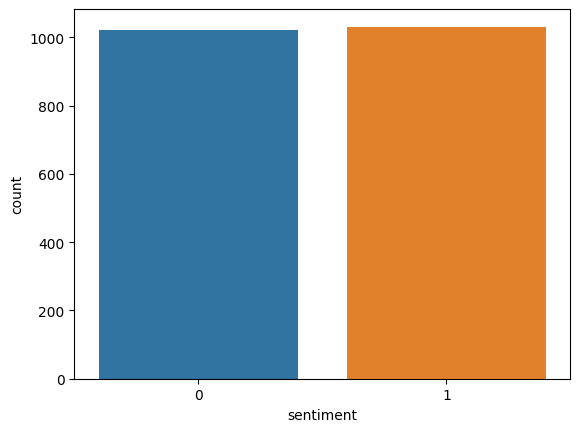

In [82]:
sns.countplot(df, x='sentiment')
plt.xlabel('sentiment')

In [83]:
class_values=[0,1]

**PREPROCESSING**

In [84]:

DarijaBERT_tokenizer = AutoTokenizer.from_pretrained("SI2M-Lab/DarijaBERT")
DarijaBert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fr

In [85]:
def repted(text):
    text=re.sub(r'(.)\1+', r'\1', text)# Replace with only one (remove repetitions)  
    return text

In [86]:
def get_emojis():
    with codecs.open("emoji.txt", "r", encoding="utf-8", errors="ignore") as myfile:
         positive_emoji=myfile.read()
    positive_emoji=positive_emoji.split("\r\n")
    positive_emoji=positive_emoji[1:len(positive_emoji)-1] 
    with codecs.open("neg_emoji.txt", "r", encoding="utf-8", errors="ignore") as myfie:
        neg_emoji=myfie.read()
    neg_emoji=neg_emoji.split("\r\n")
    neg_emoji=neg_emoji[1:len(neg_emoji)-1]
    return positive_emoji,neg_emoji

In [87]:
def emoji_to_text(text):
    text_words = []
    words = text.split(" ")
    positive_emoji,neg_emoji=get_emojis()
    for word in words:
        if emoji_pattern.search(word):
            if word in positive_emoji :
                word='ايجابي'
            if word in neg_emoji :
                word='سلبي'
        text_words.append(word)
    return ' '.join(text_words)

In [88]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [89]:
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text

In [90]:
def pre_processing(df,source,field):
    df[field] = df[source]
    df[field] = strip_links(df[field]) # remove links
    df[field] = emoji_to_text(df[field]) # replace emojies with their sentiments
    df[field] = df[field].replace(r'@[^\s]+', 'USER', regex=True) # Replace user mentions with USER string
    df[field] = df[field].replace(r'#[^\s]+', 'HASHTAG', regex=True) # Replace Hashtags with HASHTAG string
    df=df[df[field].apply(lambda x:len(re.findall(r'[\u0600-\u06FF]+', x)))>1] #Keep sequences with at least 2 arabic words
    df[field] = df[field].apply(strip_tatweel) #Remove Tatweel string 
    df[field] = df[field].apply(strip_tashkeel) # Remove Diacritics
    df[field] = df[field].apply(repted)
    return df

In [91]:
sample_txt= "ch7al zwina dnia"
sample_txt_ar=transliterate(sample_txt, source='ma', target='ar', universal=True)
tokens = DarijaBERT_tokenizer.tokenize(sample_txt_ar)
token_ids = DarijaBERT_tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt_ar}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: شحال زوينا دنيا
   Tokens: ['شحال', 'زوينا', 'دنيا']
Token IDs: [2448, 22504, 4236]


In [92]:
encoding = DarijaBERT_tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [93]:
encoding['input_ids']

tensor([[    2,  8094,  1041,  3630, 56472,    48, 19829,  1058,     3,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


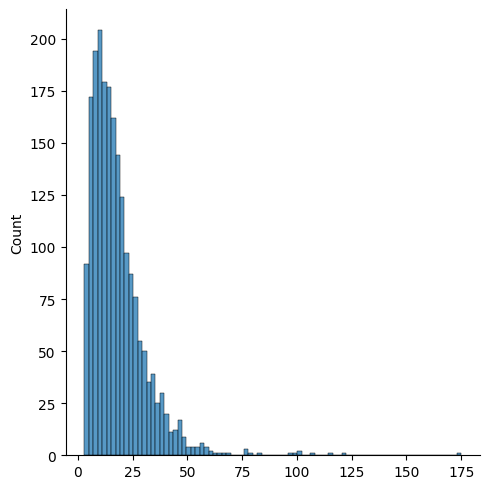

In [94]:
token_lens=[]

for txt in df.sentence:
  encodings=DarijaBERT_tokenizer.encode(txt,max_length=512)
  var=length_hint(encodings)
  token_lens.append(var)
sns.displot(token_lens)  

**Creat a Pytorch Dataset**

In [95]:
class GPSentenceDataset(Dataset):
  def __init__(self, sentences, targets, tokenizer, max_len):
    self.sentences = sentences
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.sentences)
  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
    attention_mask = torch.tensor(encoding['attention_mask'], dtype=torch.long)
    return {
      'sentence_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [96]:
for sentence in df.sentence:
  sentence= remove_emojis(sentence)

**SPLIT THE DATASET**


In [97]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

**Creat Data Loaders**

In [98]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPSentenceDataset(
    sentences=df.sentence.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [99]:
BATCH_SIZE = 16
MAX_LEN = 180
train_data_loader = create_data_loader(df_train, DarijaBERT_tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, DarijaBERT_tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, DarijaBERT_tokenizer, MAX_LEN, BATCH_SIZE)

In [100]:
ds = GPSentenceDataset(
    sentences=df.sentence.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=DarijaBERT_tokenizer,
    max_len=MAX_LEN
  )


In [101]:
df.dtypes


sentiment     int64
sentence     object
dtype: object

In [102]:
data = next(iter(train_data_loader))
data.keys()


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_34/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_34/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


dict_keys(['sentence_text', 'input_ids', 'attention_mask', 'targets'])

In [103]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 180])
torch.Size([16, 180])
torch.Size([16])


In [104]:
last_hidden_state, pooled_output = DarijaBert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [105]:
DarijaBert_model.config


BertConfig {
  "_name_or_path": "SI2M-Lab/DarijaBERT",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "cls_token": "[CLS]",
  "do_lower_case": true,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_token": "[MASK]",
  "max_len": 128,
  "max_position_embeddings": 512,
  "model_max_length": 128,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token": "[PAD]",
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sep_token": "[SEP]",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "unk_token": "[UNK]",
  "use_cache": true,
  "vocab_size": 80000
}

**Building a sentiment classifier**

In [106]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = DarijaBert_model = AutoModel.from_pretrained("SI2M-Lab/DarijaBERT", return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [107]:
model = SentimentClassifier(len(class_values))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of the model checkpoint at SI2M-Lab/DarijaBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [108]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 180])
torch.Size([16, 180])


In [109]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [110]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [111]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_34/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_34/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


0.883495145631068

In [112]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["sentence_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [113]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_34/3943356482.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoding['input_ids'], dtype=torch.long)
/tmp/ipykernel_34/3943356482.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().re

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [114]:
print(classification_report(y_test, y_pred, target_names=['négative','positif']))

              precision    recall  f1-score   support

    négative       0.83      0.94      0.88        48
     positif       0.94      0.84      0.88        55

    accuracy                           0.88       103
   macro avg       0.89      0.89      0.88       103
weighted avg       0.89      0.88      0.88       103



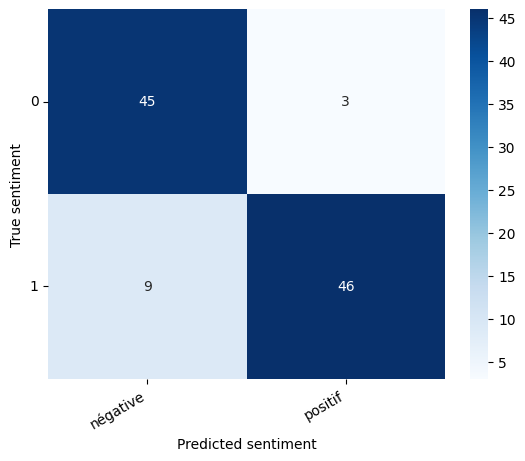

In [115]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_values, columns=['négative','positif'])
show_confusion_matrix(df_cm)

In [116]:
idx = 2
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_values': class_values,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_values[true_sentiment]}')

 أوقفوها و اريحونا من برامجها و الضرائب التي ندفعها لها ظلما و عدونا
رغما عنا

True sentiment: 0
